In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# --- Load .npy image paths and labels ---
def load_npy_images_and_labels(base_dir):
    image_paths, labels = [], []
    for label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                if file.endswith(".npy"):
                    image_paths.append(os.path.join(class_dir, file))
                    labels.append(label)
    return image_paths, labels

In [4]:
# Define folders
output_train = '/content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train'
output_valid = '/content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Valid'
output_test = '/content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Test'

In [5]:
# Load paths and labels
train_paths, train_labels = load_npy_images_and_labels(output_train)
valid_paths, valid_labels = load_npy_images_and_labels(output_valid)
test_paths, test_labels   = load_npy_images_and_labels(output_test)

In [6]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_valid = le.transform(valid_labels)
y_test  = le.transform(test_labels)
np.save('label_encoder_coloring.npy', le.classes_)

In [7]:
# Load images
def load_images_from_paths(image_paths):
    images = [np.load(p) for p in image_paths]
    return np.array(images)

X_train = load_images_from_paths(train_paths)
X_valid = load_images_from_paths(valid_paths)
X_test  = load_images_from_paths(test_paths)

In [8]:
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

In [9]:
#build CNN model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=32
    #callbacks=[early_stop]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3540 - loss: 1.9898 - val_accuracy: 0.6226 - val_loss: 1.1457
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7605 - loss: 0.9586 - val_accuracy: 0.7547 - val_loss: 0.5986
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8144 - loss: 0.4310 - val_accuracy: 0.7736 - val_loss: 0.5687
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8577 - loss: 0.3524 - val_accuracy: 0.8113 - val_loss: 0.6284
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8986 - loss: 0.2849 - val_accuracy: 0.8302 - val_loss: 0.4043
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9466 - loss: 0.1818 - val_accuracy: 0.8113 - val_loss: 0.5377
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9815 - loss: 0.0983 - val_accuracy: 0.8113 - val_loss: 0.5478
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0349 - val_accuracy: 0.8679 - val_loss: 0.5822
Epoch 9/

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7826 - loss: 0.7162
Test Accuracy: 0.782608687877655


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("Test Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
Test Report:
              precision    recall  f1-score   support

    ASD_Mild       0.67      0.33      0.44         6
ASD_Moderate       1.00      1.00      1.00         6
  ASD_Severe       0.67      1.00      0.80         6
     Non_ASD       0.80      0.80      0.80         5

    accuracy                           0.78        23
   macro avg       0.78      0.78      0.76        23
weighted avg       0.78      0.78      0.76        23



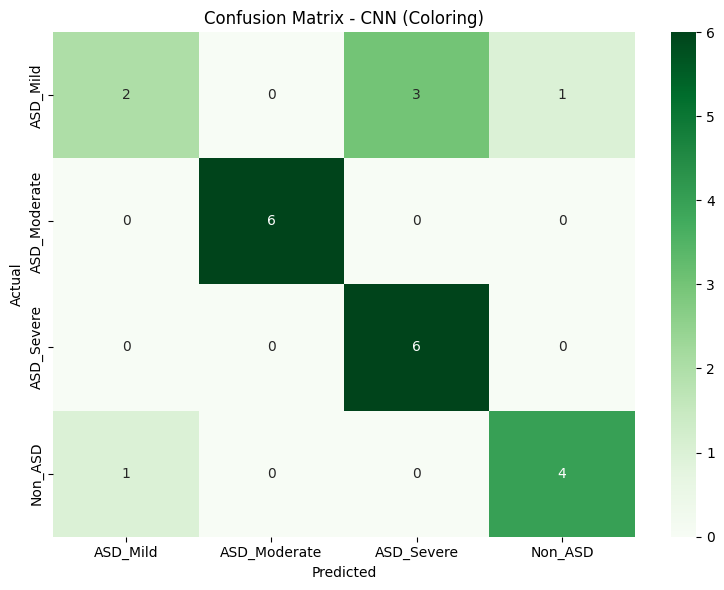

In [14]:
#Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

classes = le.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN (Coloring)')
plt.tight_layout()
plt.show()

In [15]:
# Folder where you want to save your files
save_dir = "/content/drive/MyDrive/MP_AUTISM/Coloring/Models/CNN"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "CNN_coloring_model.h5")
model.save(model_path)

import joblib

cnn_path = os.path.join(save_dir, "cnn_coloring_model.pkl")
joblib.dump(model, cnn_path)

np.save(os.path.join(save_dir, "label_encoder_coloring.npy"), le.classes_)